# Modifying Corpus
Katie Thomas  
kdt13@pitt.edu

Here I will modify the corpus to fit my own needs. I'm going to combine the post and reply files for each website, in order to look at it more cohesively.

## Table of Contents
1. [Cleaning Facebook Congress](#Facebook-Congress-posts-and-responses): cleaning up Facebook Congress posts and responses and merging them into one DataFrame
2. [Cleaning Facebook Wiki](#Facebook-wiki-posts-and-responses): cleaning up Facebook Wiki posts and responses and merging them into one DataFrame
3. [Cleaning Fitocracy](#Fitocracy-posts-and-responses): cleaning up Fitocracy posts and responses and merging them into one DataFrame
4. [Cleaning Reddit](#Reddit-posts-and-responses): cleaning up Reddit posts and responses and merging them into one DataFrame
5. [Cleaning TED](#TED-responses): cleaning up TED responses (there is no accompanying posts file)

## Setting up

In [1]:
# import things
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from scipy import stats
import pickle

In [2]:
# set corpus directory
root = "/Users/katie/Documents/Data_Science/Gendered-Interaction-Online/private/rtgender/"

## Facebook Congress posts and responses
First let's gather the posts and responses with the Facebook congress files.

In [3]:
# first, facebook congress files
fb_congress_posts = pd.read_csv(root + 'facebook_congress_posts.csv')
fb_congress_responses = pd.read_csv(root + 'facebook_congress_responses.csv')

In [4]:
fb_congress_posts.head()

,op_id,op_gender,post_id,post_text,post_type
0,57265377,M,0,"Yesterday, my colleagues and I voted to protec...",video
1,57265377,M,1,Roses are red...and so is Texas. Let's keep it...,video
2,57265377,M,2,#TBT to this classic video. #DonkeyWhisperer,video
3,57265377,M,3,Since President Donald J. Trump was sworn in o...,video
4,57265377,M,4,Remembering our 40th president today. LIKE to ...,video


From the exploratory analysis file, we saw that there were some nulls in post_text. Let's replace this with an empty string. We still need these posts in here, as they may still have some replies to them.

In [5]:
fb_congress_posts.post_text.fillna('', inplace=True)
fb_congress_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548341 entries, 0 to 548340
Data columns (total 5 columns):
op_id        548341 non-null int64
op_gender    548341 non-null object
post_id      548341 non-null int64
post_text    548341 non-null object
post_type    548341 non-null object
dtypes: int64(2), object(3)
memory usage: 20.9+ MB


Yay - no more nulls!

In [6]:
# are there duplicates in text?
fb_congress_posts.post_text.value_counts().head(10)

                                                                                                                                                                                      38206
»                                                                                                                                                                                       162
Congressman Gregg Harper welcomes folks to stop by his office in Washington to say hello. His staff wants to assure that your visit to Washington, D.C. is exciting and memorable.      117
U.S. Senate Photographic Studio-                                                                                                                                                         42
Happy Thanksgiving!                                                                                                                                                                      41
Happy Mother's Day!                                         

Why are there weirdly specific things that are duplicated? Let's look at the first 5 of the one starting with "Congressman Gregg Harper":

In [7]:
fb_congress_posts[fb_congress_posts.post_text == 'Congressman Gregg Harper welcomes folks to stop by his office in Washington to say hello. His staff wants to assure that your visit to Washington, D.C. is exciting and memorable.'].head()

,op_id,op_gender,post_id,post_text,post_type
59770,86058661,M,59770,Congressman Gregg Harper welcomes folks to sto...,photo
59773,86058661,M,59773,Congressman Gregg Harper welcomes folks to sto...,photo
59775,86058661,M,59775,Congressman Gregg Harper welcomes folks to sto...,photo
59777,86058661,M,59777,Congressman Gregg Harper welcomes folks to sto...,photo
59780,86058661,M,59780,Congressman Gregg Harper welcomes folks to sto...,photo


Weird... so the same post seems to have different post IDs? Going to look at this more once they're merged.

So how should we merge?

In [8]:
# let me see if post id is completely unique, or just unique to the op gender.
# this will let us know if we need to merge on BOTH op_id and post_id or just op_id
print(len(fb_congress_posts.post_id))
print(fb_congress_posts.post_id.nunique())

548341
548341


Yay - the post ID is unique! So we can just merge on post id.

In [9]:
# renaming some columns because hoping this to be the same as the posts file
# but still need to check
fb_congress_responses.rename(columns={'op_gender': 'op_gender2'}, inplace=True)
fb_congress_responses.head()

,op_id,op_gender2,post_id,responder_id,response_text,op_name,op_category
0,57265377,M,0,Jerry,Protecting birth is not the same as protecting...,Roger Williams,Congress_Republican
1,57265377,M,0,Andrea,You need to protect children and leave my body...,Roger Williams,Congress_Republican
2,57265377,M,0,Sherry,Thank you,Roger Williams,Congress_Republican
3,57265377,M,0,Bob,Thank you Roger,Roger Williams,Congress_Republican
4,57265377,M,0,Joy,Unwanted pregnancy is a sad and unfortunate si...,Roger Williams,Congress_Republican


In [10]:
# first, check for nulls in the response file
# commenting out the ones that have no nulls

# fb_congress_responses[fb_congress_responses.op_id.isnull()]
# fb_congress_responses[fb_congress_responses.op_gender2.isnull()]
# fb_congress_responses[fb_congress_responses.post_id.isnull()]
print(len(fb_congress_responses[fb_congress_responses.responder_id.isnull()]))
print(len(fb_congress_responses[fb_congress_responses.response_text.isnull()]))
# fb_congress_responses[fb_congress_responses.op_name.isnull()]
# fb_congress_responses[fb_congress_responses.op_category.isnull()]

16
8071


We have nulls in responder_id and response_text. Let's change these to an empty string.

In [11]:
fb_congress_responses.fillna('', inplace=True)

So we need to match up on post_id, but hopefully the op_gender is the same too? We can add everything from the posts DataFrame to the responses DataFrame, and then see if the gender and post id match.

In [12]:
# left merge, adding stuff to the responses file
fb_congress_df = fb_congress_posts.merge(fb_congress_responses, how='left', on='post_id')
print(fb_congress_df.shape)
fb_congress_df.head()

(14015811, 11)


,op_id_x,op_gender,post_id,post_text,post_type,op_id_y,op_gender2,responder_id,response_text,op_name,op_category
0,57265377,M,0,"Yesterday, my colleagues and I voted to protec...",video,57265377.0,M,Jerry,Protecting birth is not the same as protecting...,Roger Williams,Congress_Republican
1,57265377,M,0,"Yesterday, my colleagues and I voted to protec...",video,57265377.0,M,Andrea,You need to protect children and leave my body...,Roger Williams,Congress_Republican
2,57265377,M,0,"Yesterday, my colleagues and I voted to protec...",video,57265377.0,M,Sherry,Thank you,Roger Williams,Congress_Republican
3,57265377,M,0,"Yesterday, my colleagues and I voted to protec...",video,57265377.0,M,Bob,Thank you Roger,Roger Williams,Congress_Republican
4,57265377,M,0,"Yesterday, my colleagues and I voted to protec...",video,57265377.0,M,Joy,Unwanted pregnancy is a sad and unfortunate si...,Roger Williams,Congress_Republican


In [13]:
fb_congress_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14015811 entries, 0 to 14015810
Data columns (total 11 columns):
op_id_x          int64
op_gender        object
post_id          int64
post_text        object
post_type        object
op_id_y          float64
op_gender2       object
responder_id     object
response_text    object
op_name          object
op_category      object
dtypes: float64(1), int64(2), object(8)
memory usage: 1.3+ GB


In [14]:
# check if op_gender is identical to op_gender2 (we would hope so!)
mismatch = fb_congress_df[fb_congress_df.op_gender != fb_congress_df.op_gender2]
len(mismatch)

149304

In [15]:
mismatch.head()

,op_id_x,op_gender,post_id,post_text,post_type,op_id_y,op_gender2,responder_id,response_text,op_name,op_category
1393,57265377,M,35,Today is National Pearl Harbor Remembrance Day...,photo,NaN,NaN,NaN,NaN,NaN,NaN
1412,57265377,M,37,'Tis the season. Only 24 days until #Christmas!,video,NaN,NaN,NaN,NaN,NaN,NaN
3541,57265377,M,99,Enjoyed speaking to an engaging and thoughtful...,photo,NaN,NaN,NaN,NaN,NaN,NaN
3876,57265377,M,109,Sales Tax Weekend starts TODAY and ends Sunday...,link,NaN,NaN,NaN,NaN,NaN,NaN
4234,57265377,M,124,Speaking to the New York GOP delegation at the...,photo,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
mismatch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149304 entries, 1393 to 14015810
Data columns (total 11 columns):
op_id_x          149304 non-null int64
op_gender        149304 non-null object
post_id          149304 non-null int64
post_text        149304 non-null object
post_type        149304 non-null object
op_id_y          0 non-null float64
op_gender2       0 non-null object
responder_id     0 non-null object
response_text    0 non-null object
op_name          0 non-null object
op_category      0 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 13.7+ MB


So there are nulls in all of the last 6 columns. Why is this happening?

In [17]:
# fb_congress_responses[fb_congress_responses.post_id == 34]
# 34 ends at index 1392
fb_congress_responses.iloc[1390:1395]

,op_id,op_gender2,post_id,responder_id,response_text,op_name,op_category
1390,57265377,M,34,Ruby,RIP,Roger Williams,Congress_Republican
1391,57265377,M,34,Joann,"God Bless you John Glenn, you were an awe...",Roger Williams,Congress_Republican
1392,57265377,M,34,Louis,A true American hero.,Roger Williams,Congress_Republican
1393,57265377,M,36,Evan,This has nothing to do with the state of Texas...,Roger Williams,Congress_Republican
1394,57265377,M,36,Clif,Would you hire them Mr Williams? Hope the ans...,Roger Williams,Congress_Republican


Wow - it just skips right over 35. Is this just when there are no responses to this post?

Okay... a simple way to "confirm" if this is the case for all of the missing values... We know there are 149304 "mismatch" values, where the response file data is null. Let's look at the last post_id value:

In [18]:
fb_congress_posts.tail(1)

,op_id,op_gender,post_id,post_text,post_type
548340,18876566,M,548340,,link


... There are 548341 posts (because started at 0). How many unique post_id's in the response file?

In [19]:
fb_congress_responses.post_id.nunique()

399037

In [20]:
# subtract number of unique post id's in responses from the total number of posts:
548341 - 399037

149304

Awesome - this is the exact amount of the rows with mismatches and missing data!

Let's get rid of the op_id_y column and the op_gender2 column, and rename op_id_x to just op_id.

In [21]:
fb_congress_df = fb_congress_df.drop(['op_id_y', 'op_gender2'], axis=1)
fb_congress_df.rename(columns={'op_id_x':'op_id'}, inplace=True)
fb_congress_df.head()

,op_id,op_gender,post_id,post_text,post_type,responder_id,response_text,op_name,op_category
0,57265377,M,0,"Yesterday, my colleagues and I voted to protec...",video,Jerry,Protecting birth is not the same as protecting...,Roger Williams,Congress_Republican
1,57265377,M,0,"Yesterday, my colleagues and I voted to protec...",video,Andrea,You need to protect children and leave my body...,Roger Williams,Congress_Republican
2,57265377,M,0,"Yesterday, my colleagues and I voted to protec...",video,Sherry,Thank you,Roger Williams,Congress_Republican
3,57265377,M,0,"Yesterday, my colleagues and I voted to protec...",video,Bob,Thank you Roger,Roger Williams,Congress_Republican
4,57265377,M,0,"Yesterday, my colleagues and I voted to protec...",video,Joy,Unwanted pregnancy is a sad and unfortunate si...,Roger Williams,Congress_Republican


We can also reorder the columns in a way that makes more sense. Also, note that it doesn't make sense to change the index. Nothing is really specific to each row besides the responder_id (which definitely has duplicate values - as it's just first name) and the actual response text.

Let's organize it as:
- info about post
- info about poster and responder
- post text
- response text

In [22]:
cols = ['post_id','post_type','op_id','op_name','op_category','op_gender','responder_id','post_text','response_text']
fb_congress_df = fb_congress_df[cols]
fb_congress_df.head()

,post_id,post_type,op_id,op_name,op_category,op_gender,responder_id,post_text,response_text
0,0,video,57265377,Roger Williams,Congress_Republican,M,Jerry,"Yesterday, my colleagues and I voted to protec...",Protecting birth is not the same as protecting...
1,0,video,57265377,Roger Williams,Congress_Republican,M,Andrea,"Yesterday, my colleagues and I voted to protec...",You need to protect children and leave my body...
2,0,video,57265377,Roger Williams,Congress_Republican,M,Sherry,"Yesterday, my colleagues and I voted to protec...",Thank you
3,0,video,57265377,Roger Williams,Congress_Republican,M,Bob,"Yesterday, my colleagues and I voted to protec...",Thank you Roger
4,0,video,57265377,Roger Williams,Congress_Republican,M,Joy,"Yesterday, my colleagues and I voted to protec...",Unwanted pregnancy is a sad and unfortunate si...


Okay, so recalling from above, the columns with null values were op_name, op_category, responder_id, and response_text. These are from when there are no responses. We still want to keep the row though, since we can still look at the post information. Let's replace these with an empty string.

In [23]:
fb_congress_df.fillna('', inplace=True)

Finally, back to examining those weird duplicates. Let's see when post text is duplicated and there's no response...

In [24]:
duplicates = fb_congress_df[(fb_congress_df.duplicated(subset='post_text')) & (fb_congress_df.response_text == '')]
duplicates.sample(10)

,post_id,post_type,op_id,op_name,op_category,op_gender,responder_id,post_text,response_text
13205785,481767,photo,33944100,,,M,,,
3404085,105162,photo,215524,,,M,,photos,
5457218,166394,status,67572628,,,M,,Thank You,
11868998,423932,photo,74450840,,,W,,,
1753528,23298,photo,56371090,Nancy Pelosi,Congress_Democratic,W,Tsering,It was an honor today to receive the 2016 Huma...,
13391542,506786,photo,14349839,,,M,,,
7548026,285708,link,30174504,,,M,,,
9039439,309648,link,4804331,Cheri Bustos,Congress_Democratic,W,Bruce,Governor Rauner's decision to ignore the recom...,
2342715,50338,link,89989833,,,M,,,
5019987,160414,video,46506154,Marco Rubio,Congress_Republican,M,Judi,"If you elect me president, we will have a pres...",


Let's just drop all of these. It's confusing and doesn't make sense. Note that how it's formatted, we would still keep the row if there is response text or if it's the first occurrence of the duplicate.

In [25]:
fb_congress_df.drop(duplicates.index, inplace=True)

In [26]:
# make sure it worked
fb_congress_df[(fb_congress_df.duplicated(subset='post_text')) & (fb_congress_df.response_text == '')]

,post_id,post_type,op_id,op_name,op_category,op_gender,responder_id,post_text,response_text


Great - looks good.

### Pickling

In [27]:
# try to pickle

# the file seemed to be too large to just pickle it normally, so I'm splitting it into 2
fb_congress_df_list = np.array_split(fb_congress_df, 2)
len(fb_congress_df_list)

2

In [28]:
# and pickling them separately
fb_congress_df_list[0].to_pickle("fb_congress_df_part1.pkl")

In [29]:
fb_congress_df_list[1].to_pickle("fb_congress_df_part2.pkl")

In [30]:
# now load and combine them, make sure it's the same
fb_congress_df_part1 = pd.read_pickle("fb_congress_df_part1.pkl")
fb_congress_df_part2 = pd.read_pickle("fb_congress_df_part2.pkl")

In [31]:
fb_congress_df2 = fb_congress_df_part1.append(fb_congress_df_part2)
fb_congress_df2.head()

,post_id,post_type,op_id,op_name,op_category,op_gender,responder_id,post_text,response_text
0,0,video,57265377,Roger Williams,Congress_Republican,M,Jerry,"Yesterday, my colleagues and I voted to protec...",Protecting birth is not the same as protecting...
1,0,video,57265377,Roger Williams,Congress_Republican,M,Andrea,"Yesterday, my colleagues and I voted to protec...",You need to protect children and leave my body...
2,0,video,57265377,Roger Williams,Congress_Republican,M,Sherry,"Yesterday, my colleagues and I voted to protec...",Thank you
3,0,video,57265377,Roger Williams,Congress_Republican,M,Bob,"Yesterday, my colleagues and I voted to protec...",Thank you Roger
4,0,video,57265377,Roger Williams,Congress_Republican,M,Joy,"Yesterday, my colleagues and I voted to protec...",Unwanted pregnancy is a sad and unfortunate si...


Looks to be set up similarly... Let's see if it's actually the same as the original!

In [32]:
fb_congress_df.equals(fb_congress_df2)

True

Yay! So this method of pickling will work.

## Facebook wiki posts and responses
Next, let's combine the posts and responses from the other Facebook file. This is formatted very similarly (if not the same) to the first two files, so the merging process will be the same.

In [33]:
fb_wiki_posts = pd.read_csv(root + 'facebook_wiki_posts.csv')
fb_wiki_responses = pd.read_csv(root + 'facebook_wiki_responses.csv')

In [34]:
fb_wiki_posts.head()

,op_id,op_gender,post_id,post_text,post_type
0,11679984,M,0,Tornado watch in effect tonight. Be safe. Plea...,photo
1,11679984,M,1,NaN,photo
2,11679984,M,2,Temps warming up for the holiday weekend! I wi...,photo
3,11679984,M,3,Showers heading this way ..,photo
4,11679984,M,4,Storm potential update...feel free to share th...,photo


As we recall from our exploratory analysis, there are some nulls in post_text (mostly photos, videos, and links). Let's replace these with empty strings.

In [35]:
fb_wiki_posts.post_text.fillna('', inplace=True)
fb_wiki_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149448 entries, 0 to 149447
Data columns (total 5 columns):
op_id        149448 non-null int64
op_gender    149448 non-null object
post_id      149448 non-null int64
post_text    149448 non-null object
post_type    149448 non-null object
dtypes: int64(2), object(3)
memory usage: 5.7+ MB


Yay - no more nulls!

Do we have those weird duplicates again?

In [36]:
fb_wiki_posts.post_text.value_counts().head()

                                    16431
Michael Bernard Beckwith              224
HelloGiggles.com                      126
Agree?  Michael Bernard Beckwith       62
<3                                     59
Name: post_text, dtype: int64

In [37]:
fb_wiki_posts[fb_wiki_posts.post_text == 'Michael Bernard Beckwith'].head()

,op_id,op_gender,post_id,post_text,post_type
53480,40564507,M,53480,Michael Bernard Beckwith,photo
53592,40564507,M,53592,Michael Bernard Beckwith,photo
53861,40564507,M,53861,Michael Bernard Beckwith,photo
53980,40564507,M,53980,Michael Bernard Beckwith,photo
53999,40564507,M,53999,Michael Bernard Beckwith,photo


Once again - looking really strange. I'll try to look again once it's merged.

In [38]:
fb_wiki_responses.head()

,op_id,op_gender,post_id,responder_id,response_text,op_name,op_category
0,11679984,M,0,Michelle,Is this watch going to make it to LaPorte county?,Byron Miranda,Wikipedia_American_television_news_anchors
1,11679984,M,0,Melissa,Anything for Wilmington area,Byron Miranda,Wikipedia_American_television_news_anchors
2,11679984,M,0,Darlene,"Thanks, please keep us posted.",Byron Miranda,Wikipedia_American_television_news_anchors
3,11679984,M,0,Cheryl,Thanks Byron,Byron Miranda,Wikipedia_American_television_news_anchors
4,11679984,M,0,Melissa,[[STICKER]],Byron Miranda,Wikipedia_American_television_news_anchors


In [39]:
# looking for nulls
# commenting out the ones that have no nulls

# fb_wiki_responses[fb_wiki_responses.op_id.isnull()]
# fb_wiki_responses[fb_wiki_responses.op_gender.isnull()]
# fb_wiki_responses[fb_wiki_responses.post_id.isnull()]
print(len(fb_wiki_responses[fb_wiki_responses.responder_id.isnull()]))
print(len(fb_wiki_responses[fb_wiki_responses.response_text.isnull()]))
# fb_wiki_responses[fb_wiki_responses.op_name.isnull()]
# fb_wiki_responses[fb_wiki_responses.op_category.isnull()]

29
216


Okay, so we have some nulls in the responder_id and response_text. Let's change this to an empty string.

In [40]:
fb_wiki_responses.fillna('', inplace=True)

In [41]:
# again, check to make sure post_id is unique
print(len(fb_wiki_posts.post_id))
print(fb_wiki_posts.post_id.nunique())

149448
149448


Yay, post id is unique. So we can merge on post id again! Does this one have any posts without responses? First, we merge:

In [42]:
fb_wiki_df = fb_wiki_posts.merge(fb_wiki_responses, how='left', on='post_id')
print(fb_wiki_df.shape)
fb_wiki_df.head()

(10699137, 11)


,op_id_x,op_gender_x,post_id,post_text,post_type,op_id_y,op_gender_y,responder_id,response_text,op_name,op_category
0,11679984,M,0,Tornado watch in effect tonight. Be safe. Plea...,photo,11679984.0,M,Michelle,Is this watch going to make it to LaPorte county?,Byron Miranda,Wikipedia_American_television_news_anchors
1,11679984,M,0,Tornado watch in effect tonight. Be safe. Plea...,photo,11679984.0,M,Melissa,Anything for Wilmington area,Byron Miranda,Wikipedia_American_television_news_anchors
2,11679984,M,0,Tornado watch in effect tonight. Be safe. Plea...,photo,11679984.0,M,Darlene,"Thanks, please keep us posted.",Byron Miranda,Wikipedia_American_television_news_anchors
3,11679984,M,0,Tornado watch in effect tonight. Be safe. Plea...,photo,11679984.0,M,Cheryl,Thanks Byron,Byron Miranda,Wikipedia_American_television_news_anchors
4,11679984,M,0,Tornado watch in effect tonight. Be safe. Plea...,photo,11679984.0,M,Melissa,[[STICKER]],Byron Miranda,Wikipedia_American_television_news_anchors


In [43]:
# remove op_id_y and rename op_id_x to just op_id
fb_wiki_df = fb_wiki_df.drop('op_id_y', axis=1)
fb_wiki_df.rename(columns={'op_id_x':'op_id'}, inplace=True)
fb_wiki_df.head()

,op_id,op_gender_x,post_id,post_text,post_type,op_gender_y,responder_id,response_text,op_name,op_category
0,11679984,M,0,Tornado watch in effect tonight. Be safe. Plea...,photo,M,Michelle,Is this watch going to make it to LaPorte county?,Byron Miranda,Wikipedia_American_television_news_anchors
1,11679984,M,0,Tornado watch in effect tonight. Be safe. Plea...,photo,M,Melissa,Anything for Wilmington area,Byron Miranda,Wikipedia_American_television_news_anchors
2,11679984,M,0,Tornado watch in effect tonight. Be safe. Plea...,photo,M,Darlene,"Thanks, please keep us posted.",Byron Miranda,Wikipedia_American_television_news_anchors
3,11679984,M,0,Tornado watch in effect tonight. Be safe. Plea...,photo,M,Cheryl,Thanks Byron,Byron Miranda,Wikipedia_American_television_news_anchors
4,11679984,M,0,Tornado watch in effect tonight. Be safe. Plea...,photo,M,Melissa,[[STICKER]],Byron Miranda,Wikipedia_American_television_news_anchors


In [44]:
# check for mismatches on gender
mismatch = fb_wiki_df[fb_wiki_df.op_gender_x != fb_wiki_df.op_gender_y]
len(mismatch)

31637

In [45]:
mismatch.head()

,op_id,op_gender_x,post_id,post_text,post_type,op_gender_y,responder_id,response_text,op_name,op_category
16,11679984,M,1,,photo,NaN,NaN,NaN,NaN,NaN
743,11679984,M,79,"Break today, t'storms possible tomorrow. Snow ...",photo,NaN,NaN,NaN,NaN,NaN
995,11679984,M,101,http://www.nbcchicago.com/news/local/arlington...,link,NaN,NaN,NaN,NaN,NaN
1082,11679984,M,111,NORTHWESTERN MADE HISTORY LAST WEEK...BUT IT W...,link,NaN,NaN,NaN,NaN,NaN
1104,11679984,M,114,,status,NaN,NaN,NaN,NaN,NaN


In [46]:
mismatch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31637 entries, 16 to 10484060
Data columns (total 10 columns):
op_id            31637 non-null int64
op_gender_x      31637 non-null object
post_id          31637 non-null int64
post_text        31637 non-null object
post_type        31637 non-null object
op_gender_y      0 non-null object
responder_id     0 non-null object
response_text    0 non-null object
op_name          0 non-null object
op_category      0 non-null object
dtypes: int64(2), object(8)
memory usage: 2.7+ MB


We have nulls in op_gender_y, responder_id, response_text, op_name, and op_category. Let's check and make sure it's for the same reason as the last time (that there are no responses for these posts!)

In [47]:
print(fb_wiki_responses[fb_wiki_responses.post_id == 1])
print(fb_wiki_responses[fb_wiki_responses.post_id == 79])

Empty DataFrame
Columns: [op_id, op_gender, post_id, responder_id, response_text, op_name, op_category]
Index: []
Empty DataFrame
Columns: [op_id, op_gender, post_id, responder_id, response_text, op_name, op_category]
Index: []


Seems like it. So let's just replace all these nulls with empty strings again.

In [48]:
fb_wiki_df.fillna('', inplace=True)

And again fix the columns...

In [49]:
# drop op_gender_y column
fb_wiki_df = fb_wiki_df.drop('op_gender_y', axis=1)

# rename op_gender_x to just op_gender
fb_wiki_df.rename(columns={'op_gender_x':'op_gender'}, inplace=True)

# reorganize columns again, in same order
fb_wiki_df = fb_wiki_df[cols]
fb_wiki_df.head()

,post_id,post_type,op_id,op_name,op_category,op_gender,responder_id,post_text,response_text
0,0,photo,11679984,Byron Miranda,Wikipedia_American_television_news_anchors,M,Michelle,Tornado watch in effect tonight. Be safe. Plea...,Is this watch going to make it to LaPorte county?
1,0,photo,11679984,Byron Miranda,Wikipedia_American_television_news_anchors,M,Melissa,Tornado watch in effect tonight. Be safe. Plea...,Anything for Wilmington area
2,0,photo,11679984,Byron Miranda,Wikipedia_American_television_news_anchors,M,Darlene,Tornado watch in effect tonight. Be safe. Plea...,"Thanks, please keep us posted."
3,0,photo,11679984,Byron Miranda,Wikipedia_American_television_news_anchors,M,Cheryl,Tornado watch in effect tonight. Be safe. Plea...,Thanks Byron
4,0,photo,11679984,Byron Miranda,Wikipedia_American_television_news_anchors,M,Melissa,Tornado watch in effect tonight. Be safe. Plea...,[[STICKER]]


Back to looking at the weird duplicates...

In [50]:
duplicates = fb_wiki_df[(fb_wiki_df.duplicated(subset='post_text')) & (fb_wiki_df.response_text == '')]
duplicates.sample(10)

,post_id,post_type,op_id,op_name,op_category,op_gender,responder_id,post_text,response_text
225551,6508,link,98249750,,,M,,,
224820,5777,link,98249750,,,M,,,
2058622,23602,link,84499674,,,W,,,
224597,5554,link,98249750,,,M,,,
224443,5400,photo,98249750,,,M,,,
227046,8003,photo,98249750,,,M,,,
5708554,86058,link,30328617,,,W,,,
226501,7458,link,98249750,,,M,,,
10353855,147366,event,71908465,,,M,,,
224328,5285,video,98249750,,,M,,,


Again, let's drop these.

In [51]:
fb_wiki_df.drop(duplicates.index, inplace=True)

In [52]:
# make sure it worked
fb_wiki_df[(fb_wiki_df.duplicated(subset='post_text')) & (fb_wiki_df.response_text == '')]

,post_id,post_type,op_id,op_name,op_category,op_gender,responder_id,post_text,response_text


Looks good!

### Pickling

Now let's pickle! This one is a little smaller than the Congress posts, so maybe we don't have to split it first. Let's try:

In [53]:
fb_wiki_df.to_pickle("fb_wiki_df.pkl")

It worked! Make sure they're the same again...

In [54]:
fb_wiki_df2 = pd.read_pickle("fb_wiki_df.pkl")
fb_wiki_df.equals(fb_wiki_df2)

True

Looks good!

## Fitocracy posts and responses
Again, combine posts and responses. This one will be in a different format than the Facebook files, though. Let's look:

In [55]:
fitocracy_posts = pd.read_csv(root + 'fitocracy_posts.csv')
fitocracy_responses = pd.read_csv(root + 'fitocracy_responses.csv')

In [56]:
fitocracy_posts.head()

,op_id,op_gender,post_id,post_text
0,102,W,0,Thanks for the follow! I followed back :) I ...
1,104,W,1,I've decided I have this crazy goal of running...
2,104,W,2,"Umm, yeah, so those are assisted pull-ups. Bef..."
3,117,M,3,dam gurl lookin mad tone in dat pp holla bb
4,117,M,4,What's up there bear mode?


Also, as we recall from the exploratory analysis file, there were no nulls in this file!

...Are there duplicates?

In [57]:
fitocracy_posts.post_text.value_counts().head()

just joined the WTF - Welcome to Fitocracy group!        22698
Thanks for the follow!                                    5093
just joined the No Barbie Weights Here group!             4105
just joined the Girls Gone Strong on Fitocracy group!     3612
just joined the Couch to 5K group!                        2867
Name: post_text, dtype: int64

Yes - let's evaluate later.

In [58]:
fitocracy_responses.head()

,op_id,op_gender,post_id,responder_id,response_text,responder_gender
0,102,W,0,1196122,One day at a time! =],M
1,104,W,1,5867,Crazy is synonymous with awesome in this case.,W
2,104,W,2,1635,You can enter assisted pullups. Select pullups...,M
3,117,M,3,8520,"Mirin 3% bodyfat? Yeah, you are.",W
4,117,M,4,29126,"Hey! I just started a new job, so things are s...",M


There were also no nulls in the response file! We can get straight to merging.

In [59]:
# check if post_id is unique
print(len(fitocracy_posts.post_id))
print(fitocracy_posts.post_id.nunique())

318535
318535


Good, we can merge on this!

In [60]:
fitocracy_df = fitocracy_posts.merge(fitocracy_responses, how='left', on='post_id')
print(fitocracy_df.shape)
fitocracy_df.head()

(318535, 9)


,op_id_x,op_gender_x,post_id,post_text,op_id_y,op_gender_y,responder_id,response_text,responder_gender
0,102,W,0,Thanks for the follow! I followed back :) I ...,102,W,1196122,One day at a time! =],M
1,104,W,1,I've decided I have this crazy goal of running...,104,W,5867,Crazy is synonymous with awesome in this case.,W
2,104,W,2,"Umm, yeah, so those are assisted pull-ups. Bef...",104,W,1635,You can enter assisted pullups. Select pullups...,M
3,117,M,3,dam gurl lookin mad tone in dat pp holla bb,117,M,8520,"Mirin 3% bodyfat? Yeah, you are.",W
4,117,M,4,What's up there bear mode?,117,M,29126,"Hey! I just started a new job, so things are s...",M


Check to make sure the op_id_x and op_id_y columns are the same, and op_gender_x and op_gender_y columns are the same, so we can drop one of each.

In [61]:
print(fitocracy_df.op_id_x.equals(fitocracy_df.op_id_y))
print(fitocracy_df.op_gender_x.equals(fitocracy_df.op_gender_y))

True
True


Yay - we can drop these (and rename the others).

In [62]:
fitocracy_df = fitocracy_df.drop('op_id_y', axis=1).drop('op_gender_y', axis=1)
fitocracy_df.rename(columns={'op_id_x':'op_id', 'op_gender_x':'op_gender'}, inplace=True)
fitocracy_df.head()

,op_id,op_gender,post_id,post_text,responder_id,response_text,responder_gender
0,102,W,0,Thanks for the follow! I followed back :) I ...,1196122,One day at a time! =],M
1,104,W,1,I've decided I have this crazy goal of running...,5867,Crazy is synonymous with awesome in this case.,W
2,104,W,2,"Umm, yeah, so those are assisted pull-ups. Bef...",1635,You can enter assisted pullups. Select pullups...,M
3,117,M,3,dam gurl lookin mad tone in dat pp holla bb,8520,"Mirin 3% bodyfat? Yeah, you are.",W
4,117,M,4,What's up there bear mode?,29126,"Hey! I just started a new job, so things are s...",M


Now let's reorder the columns in a similar order as the Facebook files:
- info about post
- info about poster and responder
- post text
- response text

In [63]:
cols = ['post_id','op_id','op_gender','responder_id','responder_gender','post_text','response_text']
fitocracy_df = fitocracy_df[cols]
fitocracy_df.head()

,post_id,op_id,op_gender,responder_id,responder_gender,post_text,response_text
0,0,102,W,1196122,M,Thanks for the follow! I followed back :) I ...,One day at a time! =]
1,1,104,W,5867,W,I've decided I have this crazy goal of running...,Crazy is synonymous with awesome in this case.
2,2,104,W,1635,M,"Umm, yeah, so those are assisted pull-ups. Bef...",You can enter assisted pullups. Select pullups...
3,3,117,M,8520,W,dam gurl lookin mad tone in dat pp holla bb,"Mirin 3% bodyfat? Yeah, you are."
4,4,117,M,29126,M,What's up there bear mode?,"Hey! I just started a new job, so things are s..."


So - is there really only one response per post?

In [64]:
fitocracy_df.post_id.value_counts()[:10]

2047      1
86655     1
92792     1
90745     1
96890     1
94843     1
84604     1
82557     1
88702     1
305856    1
Name: post_id, dtype: int64

Yes! This must just be how the website was set up, or how the file was specifically made. Look at the duplicates:

In [65]:
fitocracy_df[fitocracy_df.post_text == 'just joined the WTF - Welcome to Fitocracy group!'].head()

,post_id,op_id,op_gender,responder_id,responder_gender,post_text,response_text
2734,2734,5378,W,138433,M,just joined the WTF - Welcome to Fitocracy group!,Welcome:)
5218,5218,11102,M,121831,M,just joined the WTF - Welcome to Fitocracy group!,tee hee
7957,7957,21841,M,324778,M,just joined the WTF - Welcome to Fitocracy group!,I like your profile pic did you make it yourself?
8726,8726,24258,W,30515,M,just joined the WTF - Welcome to Fitocracy group!,Welcome.
18082,18082,45374,W,138433,M,just joined the WTF - Welcome to Fitocracy group!,Welcome:)


Okay, this time I'm going to keep them because there's only one response per post, and the responses don't seem automated.

### Pickling

In [66]:
fitocracy_df.to_pickle("fitocracy_df.pkl")

## Reddit posts and responses
Again, we can see a new format! Let's look again and the post and response files and combine them.

In [67]:
reddit_posts = pd.read_csv(root + 'reddit_posts.csv')
reddit_responses = pd.read_csv(root + 'reddit_responses.csv')

In [68]:
reddit_posts.head()

,op_id,op_gender,post_id,post_text,subreddit,op_gender_visible
0,Kastoli,M,0,slayer task perhaps?,2007scape,False
1,Kastoli,M,1,"Black DHide legs, possibly an initiate pure?",2007scape,False
2,DCBizzle,M,2,Whats a tonk? lol,2007scape,False
3,ordona,M,3,Do the Stronghold of Security for a free 10k t...,2007scape,False
4,SlayerMaster,M,4,I cant tell if this guy just doesnt speak Engl...,2007scape,False


Recall once again that there were no nulls in the post file!

Are there duplicates?

In [69]:
reddit_posts.post_text.value_counts().head()

ping          688
Why?          332
Yes.          229
What?         208
Tom Cruise    176
Name: post_text, dtype: int64

Yes - but they seem to be okay. Except Tom Cruise - what's that about?? To be checked out later...

In [70]:
reddit_responses.head()

,op_id,op_gender,post_id,responder_id,response_text,subreddit,responder_gender,responder_gender_visible
0,Kastoli,M,0,Thunda_Storm,or low level. I mean hes wearing black armour ...,2007scape,NaN,unknown_gender
1,Kastoli,M,1,Thunda_Storm,So... Low level,2007scape,NaN,unknown_gender
2,DCBizzle,M,2,minixmatt,"<link> TONK, TONK",2007scape,NaN,unknown_gender
3,ordona,M,3,Namiweso,Thanks I forgot about that place! :),2007scape,NaN,unknown_gender
4,SlayerMaster,M,4,Quantization,Or hes just trolling.,2007scape,NaN,unknown_gender


In this response file, as we recall from the exploratory notebook file, we have a bunch of nulls in the responder_gender file. Let's replace these with an empty string.

In [71]:
reddit_responses.responder_gender.fillna('', inplace=True)
reddit_responses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453512 entries, 0 to 1453511
Data columns (total 8 columns):
op_id                       1453512 non-null object
op_gender                   1453512 non-null object
post_id                     1453512 non-null int64
responder_id                1453512 non-null object
response_text               1453512 non-null object
subreddit                   1453512 non-null object
responder_gender            1453512 non-null object
responder_gender_visible    1453512 non-null object
dtypes: int64(1), object(7)
memory usage: 88.7+ MB


Yay - all fixed! Again we hope to merge on post_id, but will still check and make sure it's unique in the post file.

In [72]:
print(len(reddit_posts.post_id))
print(reddit_posts.post_id.nunique())

1453512
1453512


Good - so we merge on post_id again!

In [73]:
reddit_df = reddit_posts.merge(reddit_responses, how='left', on='post_id')
print(reddit_df.shape)
reddit_df.head()

(1453512, 13)


,op_id_x,op_gender_x,post_id,post_text,subreddit_x,op_gender_visible,op_id_y,op_gender_y,responder_id,response_text,subreddit_y,responder_gender,responder_gender_visible
0,Kastoli,M,0,slayer task perhaps?,2007scape,False,Kastoli,M,Thunda_Storm,or low level. I mean hes wearing black armour ...,2007scape,,unknown_gender
1,Kastoli,M,1,"Black DHide legs, possibly an initiate pure?",2007scape,False,Kastoli,M,Thunda_Storm,So... Low level,2007scape,,unknown_gender
2,DCBizzle,M,2,Whats a tonk? lol,2007scape,False,DCBizzle,M,minixmatt,"<link> TONK, TONK",2007scape,,unknown_gender
3,ordona,M,3,Do the Stronghold of Security for a free 10k t...,2007scape,False,ordona,M,Namiweso,Thanks I forgot about that place! :),2007scape,,unknown_gender
4,SlayerMaster,M,4,I cant tell if this guy just doesnt speak Engl...,2007scape,False,SlayerMaster,M,Quantization,Or hes just trolling.,2007scape,,unknown_gender


Now we can check and make sure op_id_x and op_id_y are the same, op_gender_x and op_gender_y are the same, and subreddit_x and subreddit_y are the same.

In [74]:
print(reddit_df.op_id_x.equals(reddit_df.op_id_y))
print(reddit_df.op_gender_x.equals(reddit_df.op_gender_y))
print(reddit_df.subreddit_x.equals(reddit_df.subreddit_y))

True
True
True


All the same - so we can drop and replace the names!

In [75]:
reddit_df = reddit_df.drop('op_id_y', axis=1).drop('op_gender_y', axis=1).drop('subreddit_y', axis=1)
reddit_df.rename(columns={'op_id_x':'op_id', 'op_gender_x':'op_gender', 'subreddit_x':'subreddit'}, inplace=True)

In [76]:
reddit_df.head()

,op_id,op_gender,post_id,post_text,subreddit,op_gender_visible,responder_id,response_text,responder_gender,responder_gender_visible
0,Kastoli,M,0,slayer task perhaps?,2007scape,False,Thunda_Storm,or low level. I mean hes wearing black armour ...,,unknown_gender
1,Kastoli,M,1,"Black DHide legs, possibly an initiate pure?",2007scape,False,Thunda_Storm,So... Low level,,unknown_gender
2,DCBizzle,M,2,Whats a tonk? lol,2007scape,False,minixmatt,"<link> TONK, TONK",,unknown_gender
3,ordona,M,3,Do the Stronghold of Security for a free 10k t...,2007scape,False,Namiweso,Thanks I forgot about that place! :),,unknown_gender
4,SlayerMaster,M,4,I cant tell if this guy just doesnt speak Engl...,2007scape,False,Quantization,Or hes just trolling.,,unknown_gender


So we have a category called op_gender_visible. I would assume this means whether or not the op gender is visible to the responder. This is important to part of my analysis, when I want to examine how responders respond to certain genders. This part of the analysis will only be able to focus on when op gender is visible:

In [77]:
# reddit_df.op_gender_visible is a boolean array, use for fancy indexing
reddit_df_opgender = reddit_df[reddit_df.op_gender_visible]
print(reddit_df_opgender.shape)
reddit_df_opgender.head()

(135475, 10)


,op_id,op_gender,post_id,post_text,subreddit,op_gender_visible,responder_id,response_text,responder_gender,responder_gender_visible
51026,Uphoria,M,51026,I agree with this. most guys wont think twice ...,AskMen,True,QuixoticChemist,I think theyre are a few males in my lab this ...,W,True
51027,Uphoria,M,51027,For the sake of the op - The entire post from ...,AskMen,True,FerrousFlux,Just be as genuine as possible; dont draw it o...,,unknown_gender
51028,Uphoria,M,51028,I honestly wouldnt. There are two things to c...,AskMen,True,MobileD,Basically this. I would recommend holding off...,M,True
51029,satinbirdy,W,51029,Such a classic question! Im not a guy but Ive ...,AskMen,True,ninjarxa,whenever you make contact with another person ...,M,True
51030,phukka,M,51030,"If its a guy that you might see often, a co-wo...",AskMen,True,BroccoliFarts,He is a coworker but I only work with him thre...,W,True


Now let's examine the responder_gender vs. responder_gender visible files... are they basically telling us the same information? Or is the responder gender visible sometimes and not other times, even when we are aware of the responder gender?

In [78]:
# is unknown gender ever the case even when responder_gender isn't blank? probably not...
reddit_df[(reddit_df.responder_gender_visible == 'unknown_gender') & (reddit_df.responder_gender != '')]

,op_id,op_gender,post_id,post_text,subreddit,op_gender_visible,responder_id,response_text,responder_gender,responder_gender_visible


So it's 'unknown_gender' only when responder_gender is blank. Good, that's what I would think intuitively. Now how about when it's 'True' vs. 'False'?

In [79]:
reddit_df[reddit_df.responder_gender_visible == 'True'].head()

,op_id,op_gender,post_id,post_text,subreddit,op_gender_visible,responder_id,response_text,responder_gender,responder_gender_visible
51026,Uphoria,M,51026,I agree with this. most guys wont think twice ...,AskMen,True,QuixoticChemist,I think theyre are a few males in my lab this ...,W,True
51028,Uphoria,M,51028,I honestly wouldnt. There are two things to c...,AskMen,True,MobileD,Basically this. I would recommend holding off...,M,True
51029,satinbirdy,W,51029,Such a classic question! Im not a guy but Ive ...,AskMen,True,ninjarxa,whenever you make contact with another person ...,M,True
51030,phukka,M,51030,"If its a guy that you might see often, a co-wo...",AskMen,True,BroccoliFarts,He is a coworker but I only work with him thre...,W,True
51031,BroccoliFarts,W,51031,He is a coworker but I only work with him thre...,AskMen,True,phukka,"Also, watch how he interacts with his other co...",M,True


In [80]:
reddit_df[reddit_df.responder_gender_visible == 'False'].head()

,op_id,op_gender,post_id,post_text,subreddit,op_gender_visible,responder_id,response_text,responder_gender,responder_gender_visible
18,Tazzak9028,M,18,"If youre using 07, just click on the black par...",2007scape,False,phySi0,"Dont know why youre being downvoted, this work...",M,False
851,McFondlebutt,M,851,Four months later: Dragon hastas are dead con...,2007scape,False,TheGreatRoh,Their only use would be not unequipping your s...,M,False
972,HumerousMoniker,M,972,I read this as >your email and Ill... get in...,AdviceAnimals,False,uberguby,Isnt that what it says...?,M,False
1012,sparkymonroe,W,1012,I disagree. I consider a gamer to be someone w...,AdviceAnimals,False,uberguby,I never liked the term gamer. Wtf does that me...,M,False
1013,uberguby,M,1013,I never liked the term gamer. Wtf does that me...,AdviceAnimals,False,sparkymonroe,Ill admit Im mostly annoyed because I JUST had...,W,False


In [81]:
# is it ever the case that the responder_gender_visible column is True or False when responder_gender isn't known?
reddit_df[(reddit_df.responder_gender_visible != 'unknown_gender') & (reddit_df.responder_gender == '')]

,op_id,op_gender,post_id,post_text,subreddit,op_gender_visible,responder_id,response_text,responder_gender,responder_gender_visible


Okay good - so this works as we would hope. However, still unsure if I need the 'responder_gender_visible' column. For my analysis, I want to focus on how the responders react to the posters, based on their gender. But I don't believe the poster ever responds back to the responder, so I don't know if it matters if their gender is actually visible or not. For now, I'll keep it in and I'll reorganize the columns in a similar manner:
- info about post
- info about poster and responder
- post text
- response text

In [82]:
cols = ['post_id','subreddit','op_id','op_gender','op_gender_visible','responder_id',
        'responder_gender','responder_gender_visible','post_text','response_text']

reddit_df = reddit_df[cols]
reddit_df.head()

,post_id,subreddit,op_id,op_gender,op_gender_visible,responder_id,responder_gender,responder_gender_visible,post_text,response_text
0,0,2007scape,Kastoli,M,False,Thunda_Storm,,unknown_gender,slayer task perhaps?,or low level. I mean hes wearing black armour ...
1,1,2007scape,Kastoli,M,False,Thunda_Storm,,unknown_gender,"Black DHide legs, possibly an initiate pure?",So... Low level
2,2,2007scape,DCBizzle,M,False,minixmatt,,unknown_gender,Whats a tonk? lol,"<link> TONK, TONK"
3,3,2007scape,ordona,M,False,Namiweso,,unknown_gender,Do the Stronghold of Security for a free 10k t...,Thanks I forgot about that place! :)
4,4,2007scape,SlayerMaster,M,False,Quantization,,unknown_gender,I cant tell if this guy just doesnt speak Engl...,Or hes just trolling.


Check out the Tom Cruise duplicates...

In [83]:
reddit_df[reddit_df.post_text == 'Tom Cruise'].sample(10)

,post_id,subreddit,op_id,op_gender,op_gender_visible,responder_id,responder_gender,responder_gender_visible,post_text,response_text
293086,293086,AskReddit,KingOCarrotFlowers,M,False,lmoj1,,unknown_gender,Tom Cruise,Tom Cruise
254393,254393,AskReddit,KingOCarrotFlowers,M,False,EJR94,,unknown_gender,Tom Cruise,Tom Cruise
258669,258669,AskReddit,KingOCarrotFlowers,M,False,lmoj1,,unknown_gender,Tom Cruise,Tom Cruise
295646,295646,AskReddit,KingOCarrotFlowers,M,False,lmoj1,,unknown_gender,Tom Cruise,Tom Cruise
1282388,1282388,teenagers,ghiiirocker1,M,False,Overthelake,M,False,Tom Cruise,Qu estas Tom Cruise Port favor?
254321,254321,AskReddit,KingOCarrotFlowers,M,False,EJR94,,unknown_gender,Tom Cruise,Tom Cruise
290842,290842,AskReddit,KingOCarrotFlowers,M,False,lmoj1,,unknown_gender,Tom Cruise,Tom Cruise
260774,260774,AskReddit,KingOCarrotFlowers,M,False,EJR94,,unknown_gender,Tom Cruise,Tom Cruise
296318,296318,AskReddit,KingOCarrotFlowers,M,False,lmoj1,,unknown_gender,Tom Cruise,Tom Cruise
229998,229998,AskReddit,kreactor,M,False,Sontikka,,unknown_gender,Tom Cruise,Tom Cruise


Okay I actually think this is some sort of inside joke on Reddit where they just post "Tom Cruise" over and over again. I'm just going to get rid of these because there's less than 200 and they aren't helping out my analysis in any way.

In [84]:
reddit_df.drop(reddit_df[reddit_df.post_text == 'Tom Cruise'].index, inplace=True)

# check to make sure
reddit_df[reddit_df.post_text == 'Tom Cruise']

,post_id,subreddit,op_id,op_gender,op_gender_visible,responder_id,responder_gender,responder_gender_visible,post_text,response_text


Cool - got rid of that weird stuff!

### Pickling

In [85]:
# again, pickle it
reddit_df.to_pickle("reddit_df.pkl")

### Look at subreddits briefly
From our exploratory analysis, we saw there were a lot more male posters and responders. Let's examine if the high count of males is due to the subreddit "AskMen".

In [86]:
subgroups = reddit_df.groupby('subreddit').op_gender.value_counts()
subgroups_df = subgroups.unstack()
subgroups_df.head()

op_gender,M,W
subreddit,,
2007scape,886.0,42.0
AdviceAnimals,25524.0,8440.0
Amd,860.0,19.0
AskMen,110542.0,23378.0
AskOuija,98.0,19.0


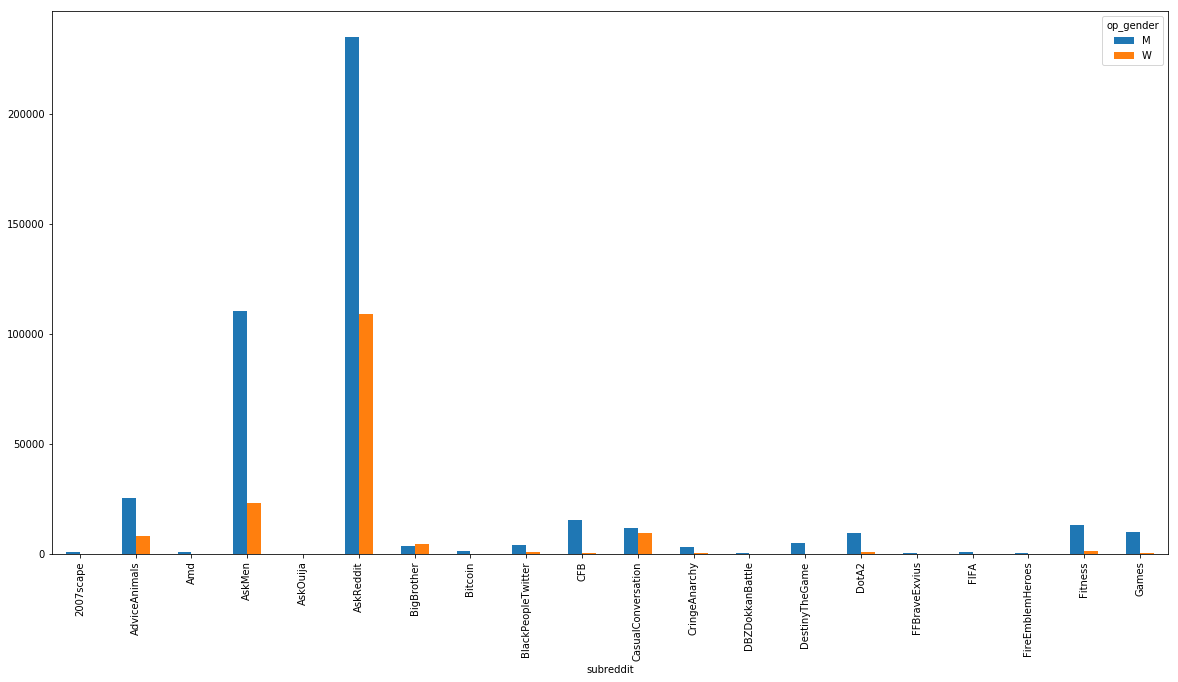

In [87]:
subgroups_df[:20].plot(kind='bar', figsize=(20,10))

Hm... so just looking at a flash of the data, 'AskMen' doesn't seem to stand out as a much higher male:female ratio. It seems like most have more male. Maybe Reddit is just a male-dominated site.

Are there any groups where there are more women? From the graph, it looks like the subreddit "BigBrother" has more female posters. Let's see what else...

In [88]:
subgroups_df[subgroups_df.W > subgroups_df.M]

op_gender,M,W
subreddit,,
BigBrother,3564.0,4647.0
aww,4400.0,4597.0
counting,267.0,531.0
relationships,10951.0,23858.0
rupaulsdragrace,153.0,728.0


Only 5!

## TED responses
Finally, we look at the responses to TED talks. Here, this is nothing to merge. We just have the response file. Let's look at it again.

In [89]:
ted_responses_df = pd.read_csv(root + 'ted_responses.csv')
print(ted_responses_df.shape)
ted_responses_df.head()

(190414, 5)


,op_id,op_gender,post_id,responder_id,response_text
0,Aimee Mullins,W,0,Laura,"She seems like a truly amazing person, regardl..."
1,Aimee Mullins,W,1,Ellen,"Aimee's true ""disability"" is when people treat..."
2,Aimee Mullins,W,2,Tanya,I love that she took away some of the mystery ...
3,Aimee Mullins,W,3,Salim,VERY inspiring indeed! I love these TED antiqu...
4,Aimee Mullins,W,4,Kiruba,We take running so much for granted that most ...


Since there's nothing to merge, let's just reorder the columns similarly to the other data frames.

In [90]:
cols = ['post_id', 'op_id', 'op_gender', 'responder_id', 'response_text']

ted_responses_df = ted_responses_df[cols]
ted_responses_df.head()

,post_id,op_id,op_gender,responder_id,response_text
0,0,Aimee Mullins,W,Laura,"She seems like a truly amazing person, regardl..."
1,1,Aimee Mullins,W,Ellen,"Aimee's true ""disability"" is when people treat..."
2,2,Aimee Mullins,W,Tanya,I love that she took away some of the mystery ...
3,3,Aimee Mullins,W,Salim,VERY inspiring indeed! I love these TED antiqu...
4,4,Aimee Mullins,W,Kiruba,We take running so much for granted that most ...


Looks good! Check for nulls...

In [91]:
ted_responses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190414 entries, 0 to 190413
Data columns (total 5 columns):
post_id          190414 non-null int64
op_id            190347 non-null object
op_gender        190347 non-null object
responder_id     190413 non-null object
response_text    190414 non-null object
dtypes: int64(1), object(4)
memory usage: 7.3+ MB


There are some nulls in op_id, op_gender, and responder_id. Let's see...

In [92]:
nulls = ted_responses_df[(ted_responses_df.op_id.isnull()) | (ted_responses_df.op_gender.isnull())
                 | (ted_responses_df.responder_id.isnull())]
print(nulls.shape)
nulls

(70, 5)


,post_id,op_id,op_gender,responder_id,response_text
13017,13017,NaN,W,larry,"Really a educative and informative post, the p..."
13018,13018,"talks, TEDx, business, cities, collaboration, ...",NaN,1291,Rachel Botsman
48424,48424,Kevin Briggs,M,NaN,You know that joke about calling the suicide h...
83960,83960,NaN,NaN,"talks,",315
83962,83962,NaN,NaN,"talks,",315
83964,83964,NaN,NaN,"talks,",315
83966,83966,NaN,NaN,"talks,",315
83968,83968,NaN,NaN,"talks,",315
83970,83970,NaN,NaN,"talks,",315
83972,83972,NaN,NaN,"talks,",315


Something weird is going on here... I may have to examine the actual file.

File examination notes:
- Post 13017: This one is okay - just doesn't have an op_id (will fill with empty string).
- Post 13018: This one is all mixed up and doesn't make any sense, so I'm just going to delete it.
- Posts 83960-84088: Something really weird is going on with these posts (but only the even numbers! The odd numbers are okay.). They are all the same and don't make any sense, and are therefore irrelevant. I'm just going to delete these rows entirely.
- Post 167976: This one is also file, just doesn't have an op_id (will fill with empty string).
- Post 167977: Again, this one is all mixed up and doesn't make any sense, so I'm going to delete it.

Whatever is happening with 13017-13018 and 167976-167977 is the same thing. Both responder ids for the first file in each pair are "larry", where there's no op_id. Also, they both have that weird string of "talks, TEDx, business, creativity, culture, design, technology, work!" as the op_id in the second file in each pair, with the atual op_id as the response text. Lastly, the response text from "larry" is exactly the same in both: "Really a educative and informative post, the post is good in all regards,I am glad to read this post. [REDACTED: some sketchy link] Christmas Deals!" Clearly, "larry" is some sort of scam posting and it may have messed up the formatting. I'm not going to delete the scam post, but I will delete the nonsense row that comes after it. Whew!

In [93]:
# first fill nulls with empty string
ted_responses_df.fillna('', inplace=True)

In [94]:
# get rid of the weird mixed up rows
#ted_responses_df = ted_responses_df.drop(ted_responses_df.index[[13018, 167977]])
ted_responses_df = ted_responses_df[~ted_responses_df.op_id.str.startswith('talks, TEDx')]
ted_responses_df.shape

(190412, 5)

Good, so we only got rid of those 2 weird rows. Now only getting rid of the ones that just say "315" in the response text.

In [95]:
ted_responses_df = ted_responses_df[ted_responses_df.response_text != "315"]
ted_responses_df.shape

(190347, 5)

Okay so we got rid of everything weird!

In [96]:
ted_responses_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190347 entries, 0 to 190413
Data columns (total 5 columns):
post_id          190347 non-null int64
op_id            190347 non-null object
op_gender        190347 non-null object
responder_id     190347 non-null object
response_text    190347 non-null object
dtypes: int64(1), object(4)
memory usage: 8.7+ MB


Lastly - any duplicate responses that are meaningful?

In [97]:
ted_responses_df.response_text.value_counts().head(10)

Thank you for your TED talk!    63
good                            54
Amazing!                        53
Brilliant!                      42
nice                            39
Awesome                         31
great                           30
nice post                       28
Amazing                         27
Great talk!                     26
Name: response_text, dtype: int64

Okay - so this just seems like the usual duplicates we would get.

### Pickling
Our last pickle!

In [98]:
# pickle it
ted_responses_df.to_pickle("ted_responses_df.pkl")